In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(".."))

# Comparison with synthetic data

We shall compare our comparison methods (ahem) with a real geographic region (Chicago North Side, for variety) three models (detailed below, all are (in)homogeneous Poisson processes) and with 3 choices of "rate", governing the expected number of "actual" events to test against.  Our "predictions" will be the same as the models, to see how well a model fits data from a different model.

### Model 1

[Complete Spatial Random-ness](https://en.wikipedia.org/wiki/Complete_spatial_randomness).

### Model 2

A simple inhomogeneous poisson process with intensity varying linearly in the x direction across the geometry

### Model 3


## Procedure

Everything will happen on a grid of size of 150m

In [2]:
%matplotlib inline
from common import *

# The geometry and grid

In [3]:
#datadir = open_cp.sources.chicago.set_data_directory(os.path.join("..", "..", "..", "..", "Data"))
datadir = open_cp.sources.chicago.set_data_directory(os.path.join("/media", "disk", "Data"))
northside, grid = load(datadir)

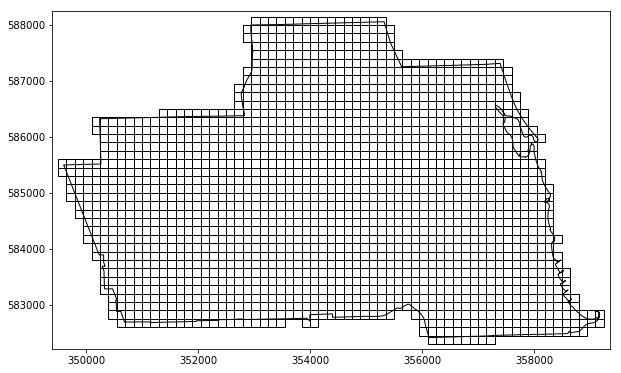

In [4]:
p = open_cp.plot.patches_from_grid(grid)

fig, ax = plt.subplots(figsize=(10,10))
ax.add_collection(matplotlib.collections.PatchCollection(p, facecolor="none", edgecolor="black"))
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))

xmin, ymin, xmax, ymax = northside.bounds
d = 200
ax.set(xlim=[xmin-d,xmax+d], ylim=[ymin-d, ymax+d])
ax.set_aspect(1)
None

# The models

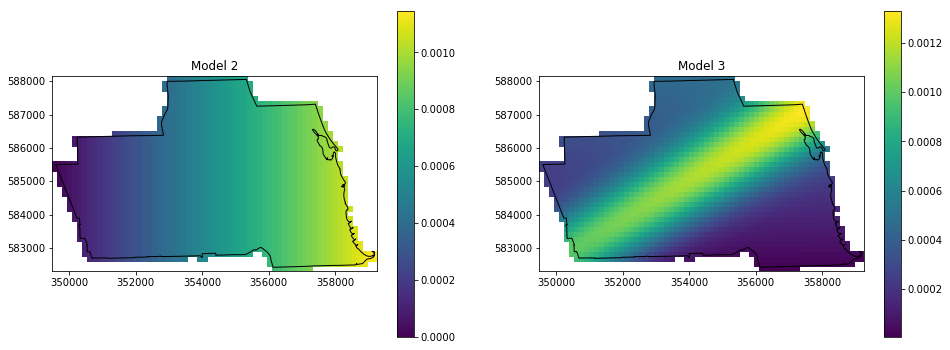

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(16,6))

for ax, Model in zip(axes, [Model2, Model3]):
    ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
    ax.set_aspect(1)
    m = Model(grid)
    pred = m.to_prediction()
    m = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix)
    plt.colorbar(m, ax=ax)

axes[0].set_title("Model 2")
axes[1].set_title("Model 3")
None

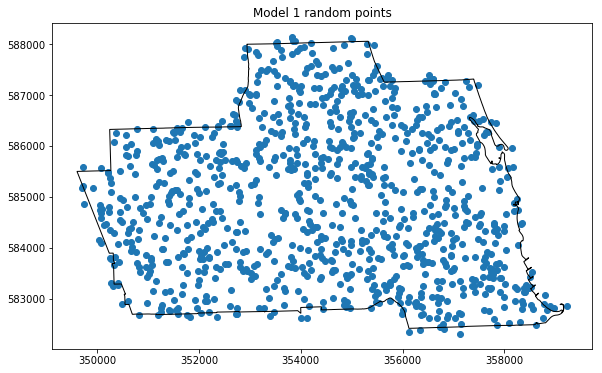

In [6]:
fig, ax = plt.subplots(figsize=(12,6))
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
m = Model1(grid)
pt = sample(m, 1000)
ax.scatter(*pt.T)
ax.set_title("Model 1 random points")
None

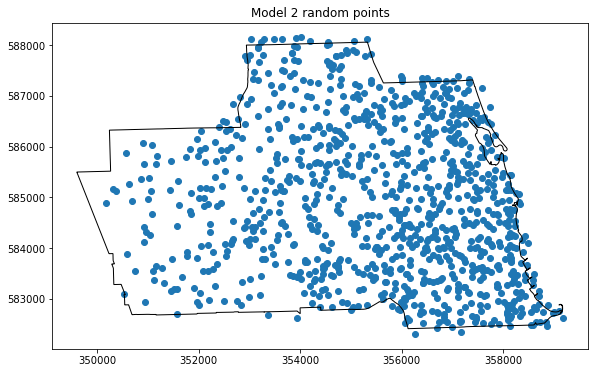

In [7]:
fig, ax = plt.subplots(figsize=(12,6))
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
m = Model2(grid)
pt = sample(m, 1000)
ax.scatter(*pt.T)
ax.set_title("Model 2 random points")
None

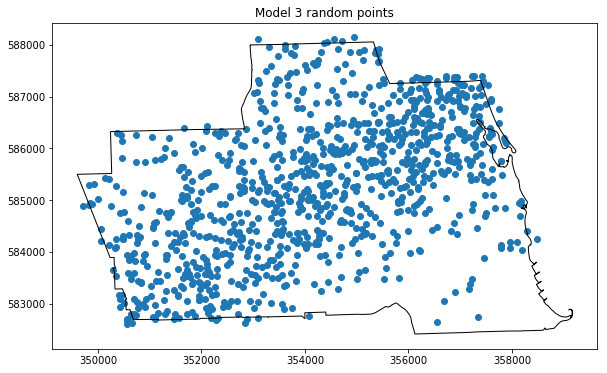

In [8]:
fig, ax = plt.subplots(figsize=(12,6))
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
m = Model3(grid)
pt = sample(m, 1000)
ax.scatter(*pt.T)
ax.set_title("Model 3 random points")
None

# Run evaluations

In [9]:
all_preds = make_data_preds(grid, num_trials=100, base_intensity=10)

## Hit rate

- As `Model1` assigns the same probability to all grid cells, for computing the hit rate, we add a very small random perturbation.

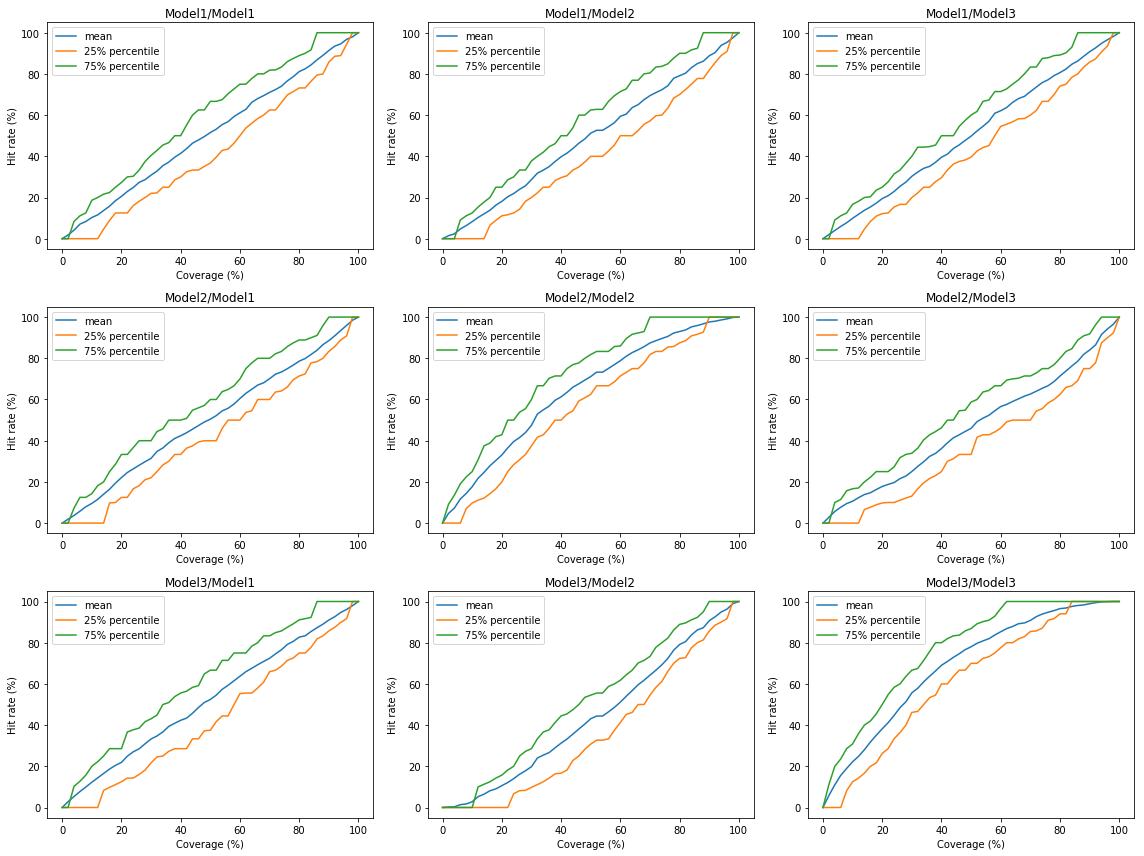

In [10]:
data = process(all_preds, open_cp.evaluation.inverse_hit_rates)
plot_hit_rate(data)

### Visualise at 20% coverage

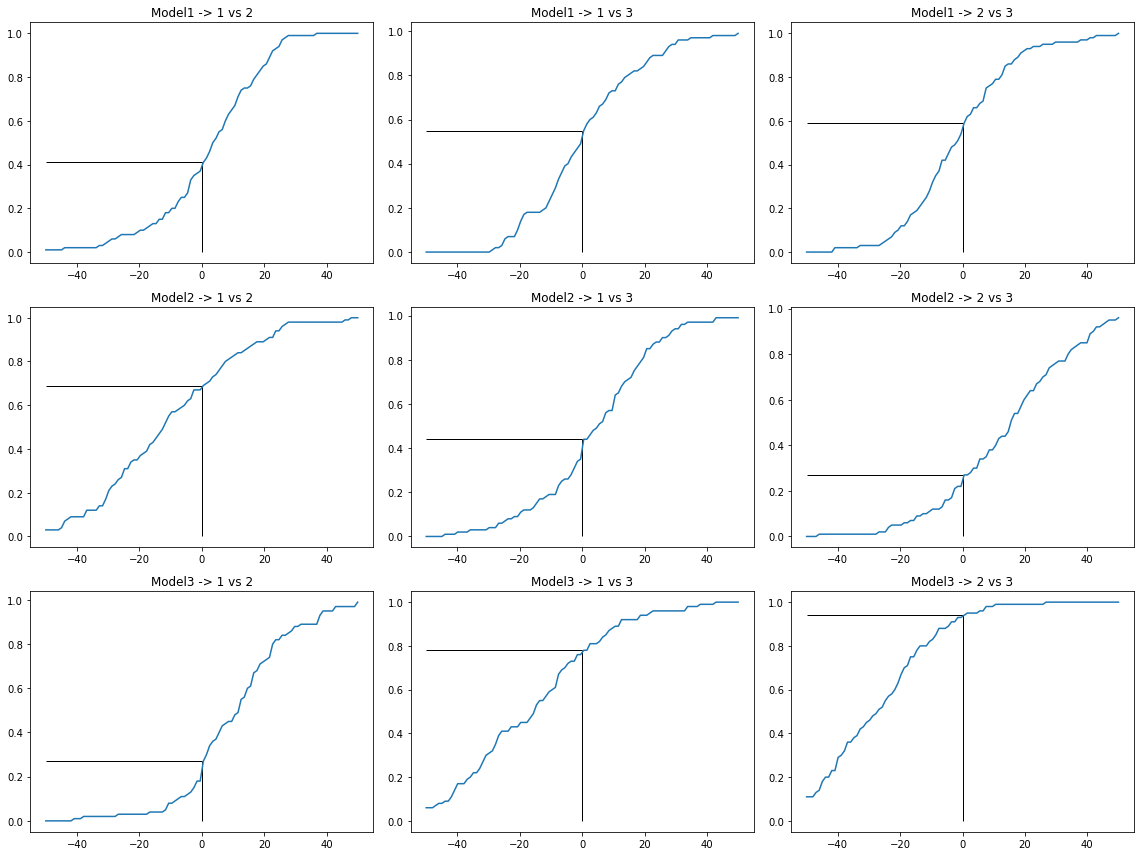

In [20]:
new_data = { k : hitrate_inverse_to_hitrate(v, {20})[20] for k,v in data.items()}
fig, axes = plot_paired_data(new_data, comparison_uni_paired(-50, 50))

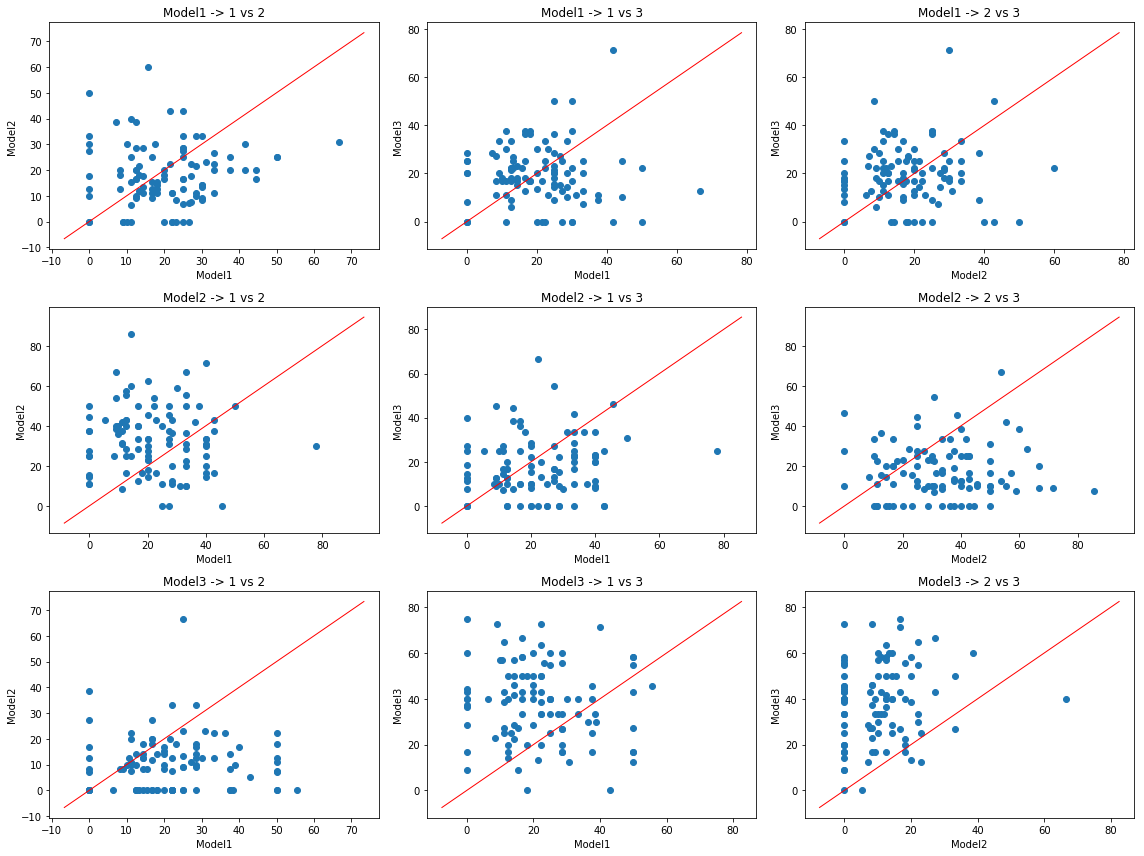

In [18]:
fig, axes = plot_paired_data(new_data, scatter_uni_paired_plot_func)
label_scatter_uni_paired(fig, axes)

## Likelihood

The upper-left corner plots the cumulative density of the log likelihood for model 1 minus the log likelihood for model 2.  Most of the mass is $\geq 0$ which means that most of the time, model 1 has a higher log likelihood, which we expect.

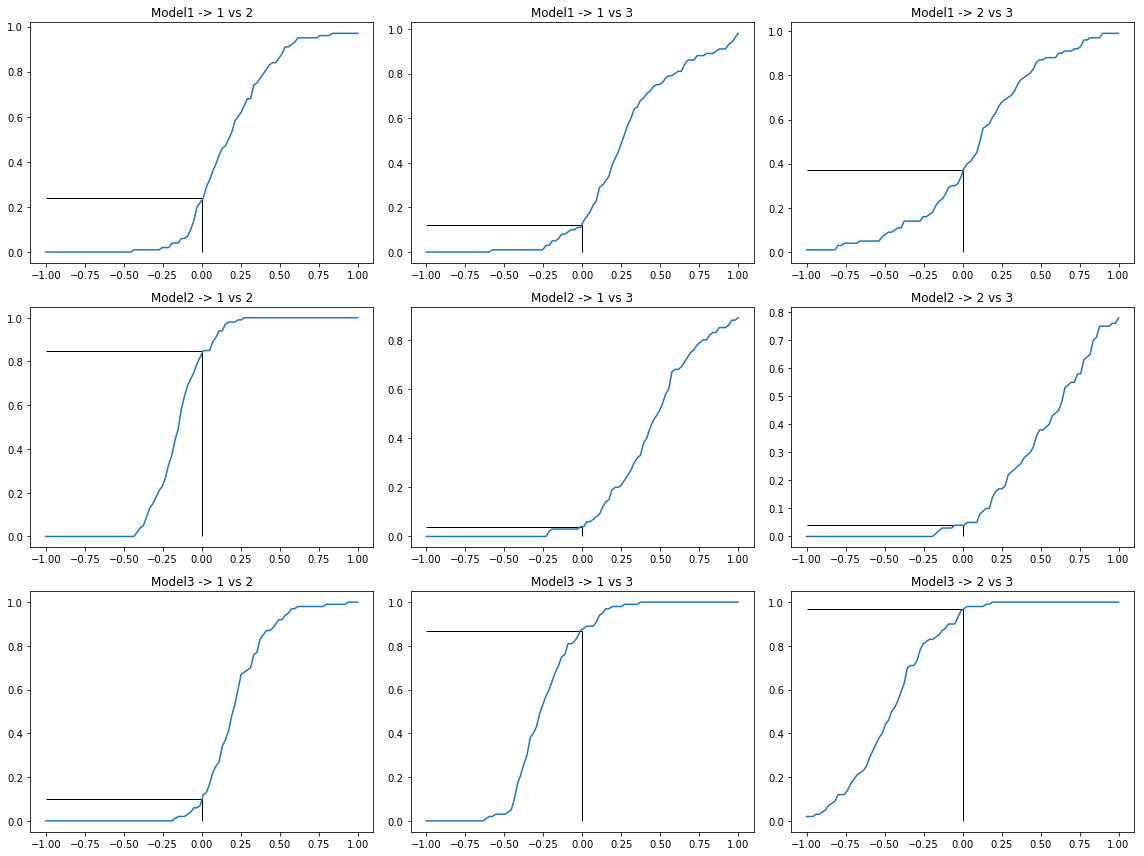

In [21]:
data = process(all_preds, open_cp.evaluation.likelihood)
fig, axes = plot_paired_data(data, comparison_uni_paired(-1, 1))

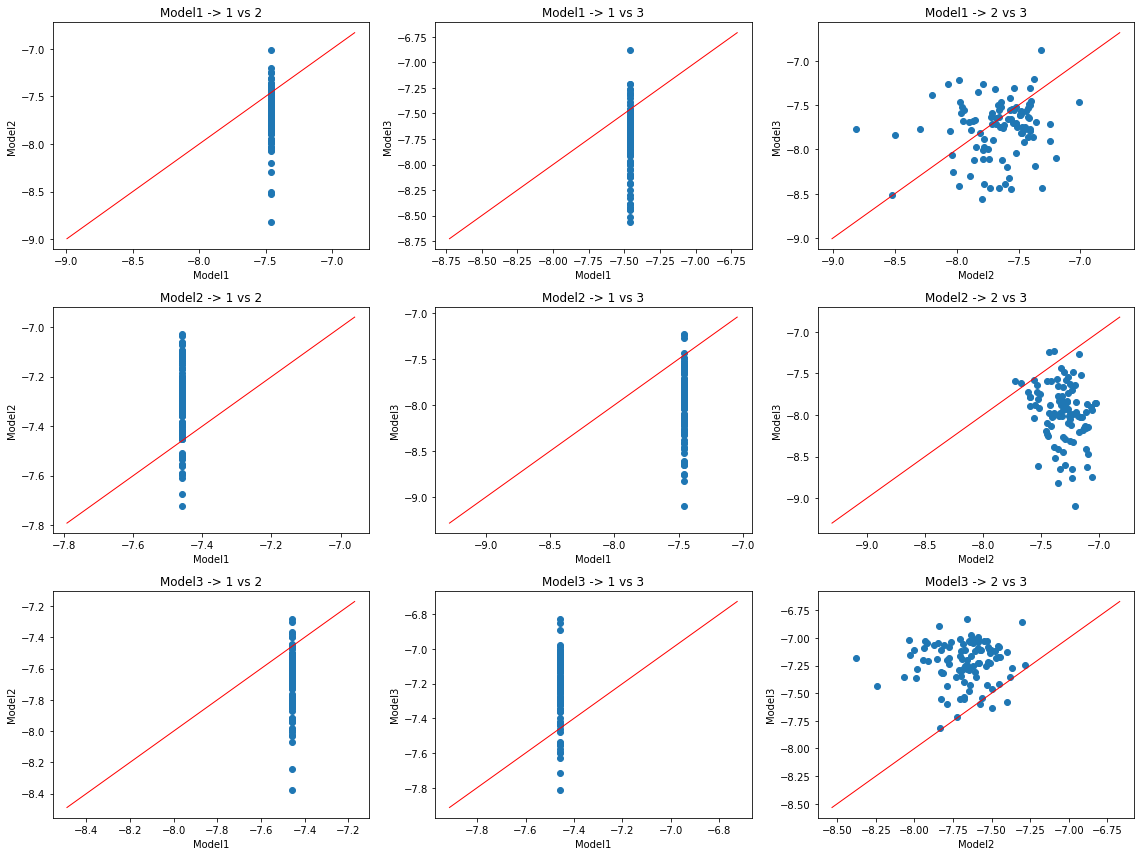

In [22]:
fig, axes = plot_paired_data(data, scatter_uni_paired_plot_func)
label_scatter_uni_paired(fig, axes)

# Ranking

Compute the mean of the "ranking".  Higher is better.

In [23]:
def func(pred, tps):
    rankings = open_cp.evaluation.ranking_score(pred, tps)
    return np.mean(rankings)

data = process(all_preds, func)

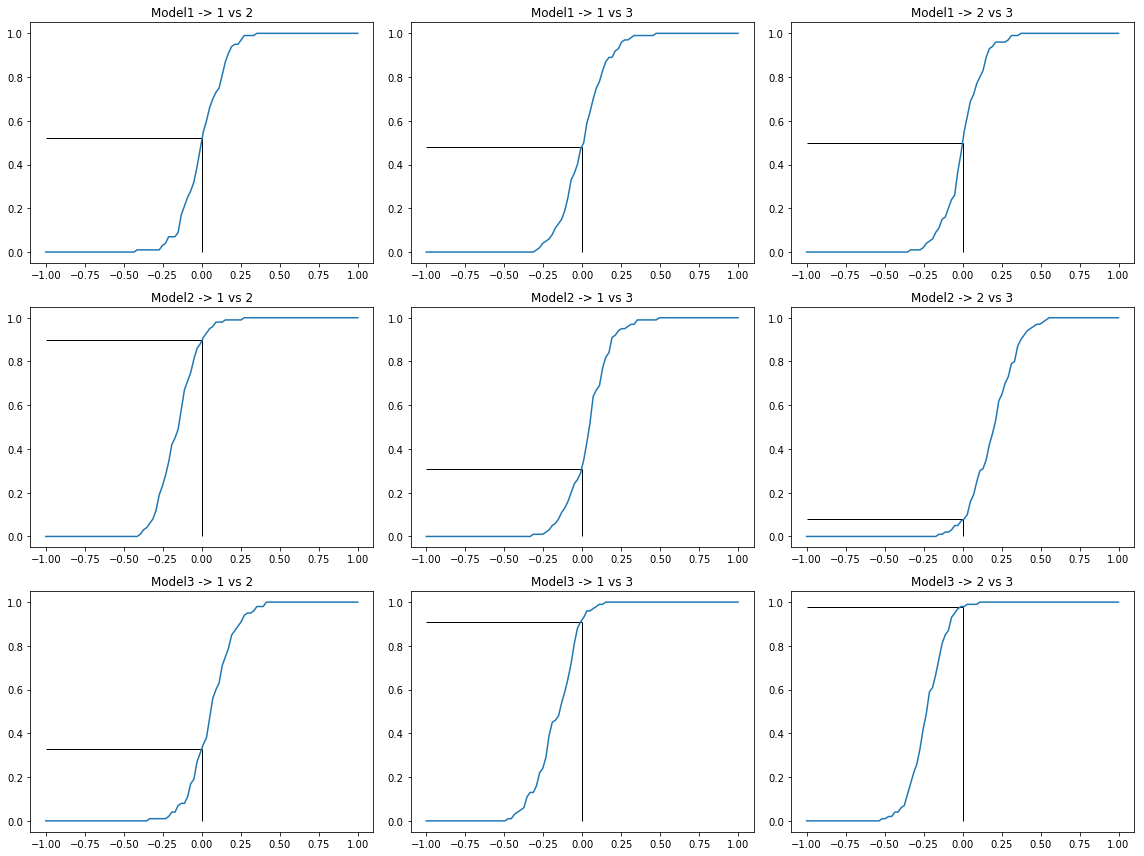

In [24]:
_ = plot_paired_data(data, comparison_uni_paired(-1, 1))

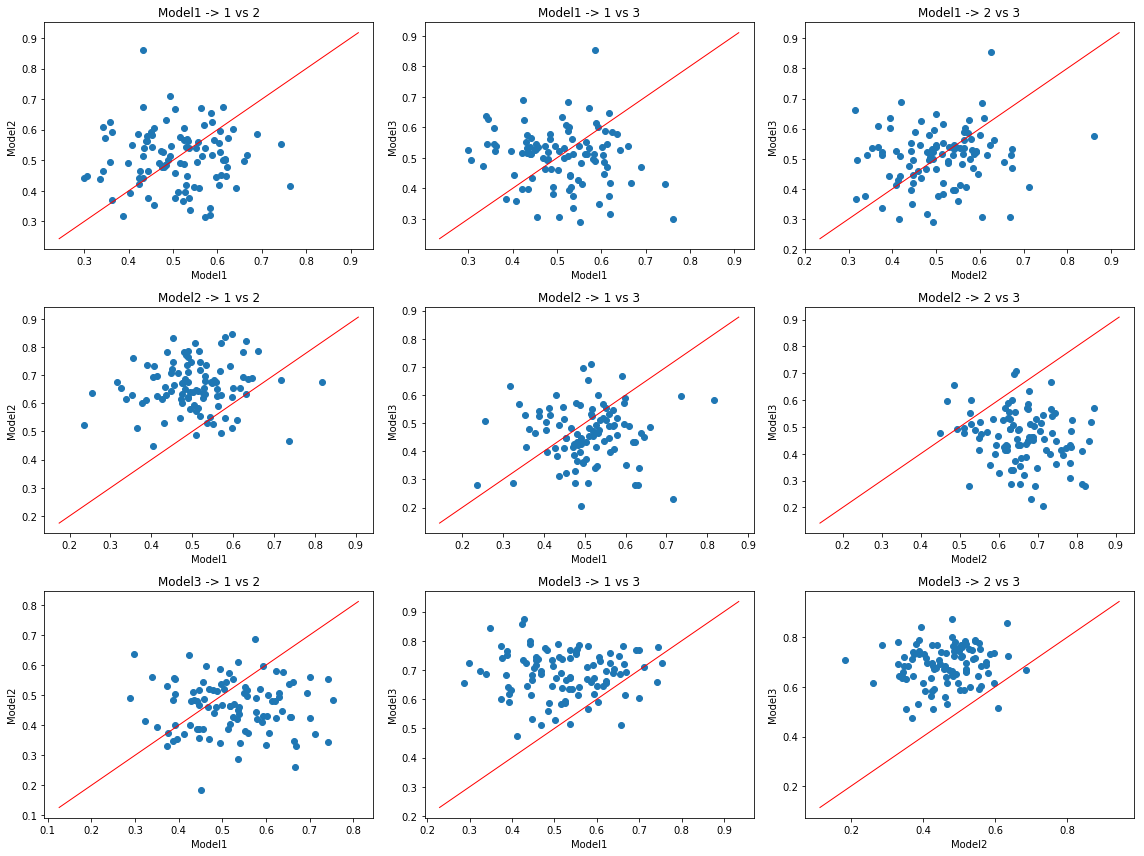

In [25]:
fig, axes = plot_paired_data(data, scatter_uni_paired_plot_func)
label_scatter_uni_paired(fig, axes)

## KDE

Firstly we show an example visualisation; then score the result.

In [26]:
m = Model3(grid)
pt = sample(m, 100)
kernel = open_cp.kernels.GaussianEdgeCorrectGrid(pt.T, grid)
pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
pred = pred.renormalise()

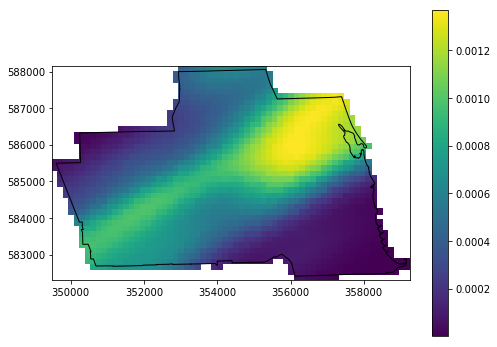

In [27]:
fig, ax = plt.subplots(figsize=(8,6))

ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
m = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix)
plt.colorbar(m, ax=ax)

In [28]:
data = process(constrain_to_number_events(all_preds, 3), kde_scorer(grid))

As we measure squared error, "smaller is better" and so we would hope to see the opposite pattern to the "likelihood" case above.

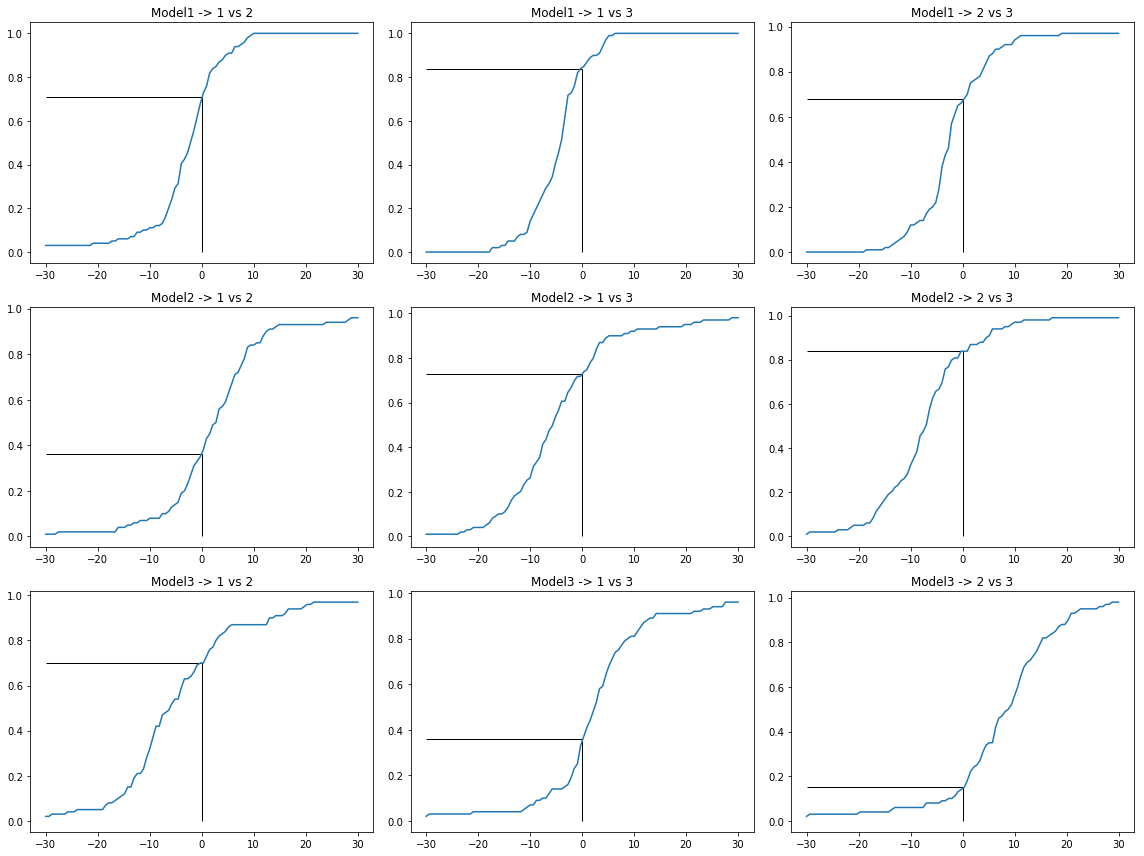

In [29]:
_ = plot_paired_data(data, comparison_uni_paired(-30, 30))

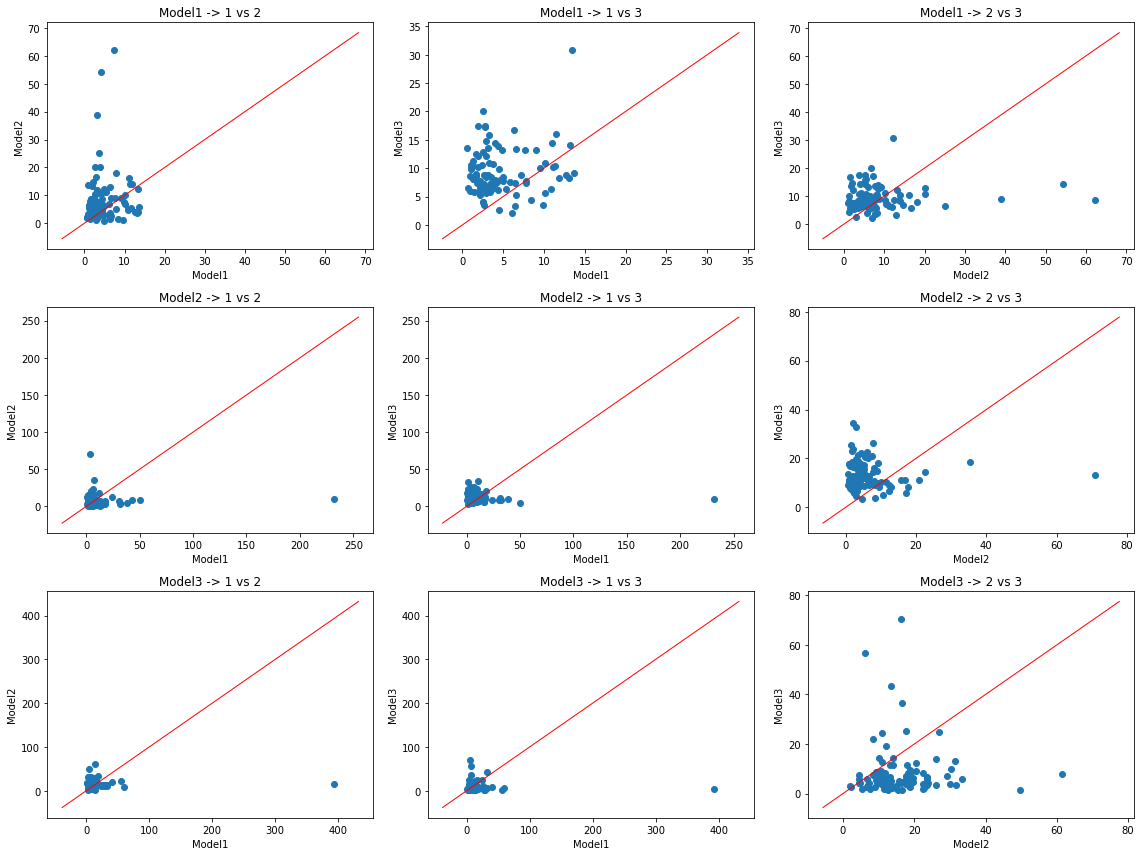

In [30]:
label_scatter_uni_paired(*plot_paired_data(data, scatter_uni_paired_plot_func))

### Smaller bandwidth

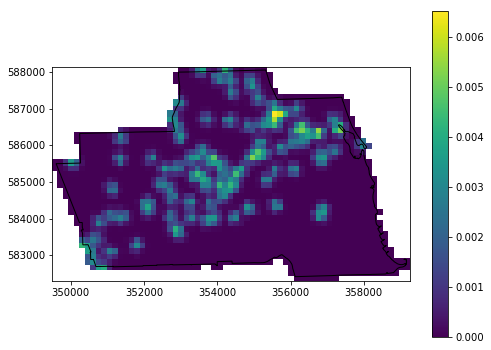

In [31]:
m = Model3(grid)
pt = sample(m, 100)
kernel = open_cp.kernels.GaussianEdgeCorrectGrid(pt.T, grid)
kernel.covariance_matrix = [[1,0],[0,1]]
kernel.bandwidth = 100
pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
pred = pred.renormalise()

fig, ax = plt.subplots(figsize=(8,6))

ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
m = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix)
plt.colorbar(m, ax=ax)
None

In [32]:
data = process(constrain_to_number_events(all_preds, 3), kde_scorer_fixed_bandwidth(grid, 100))

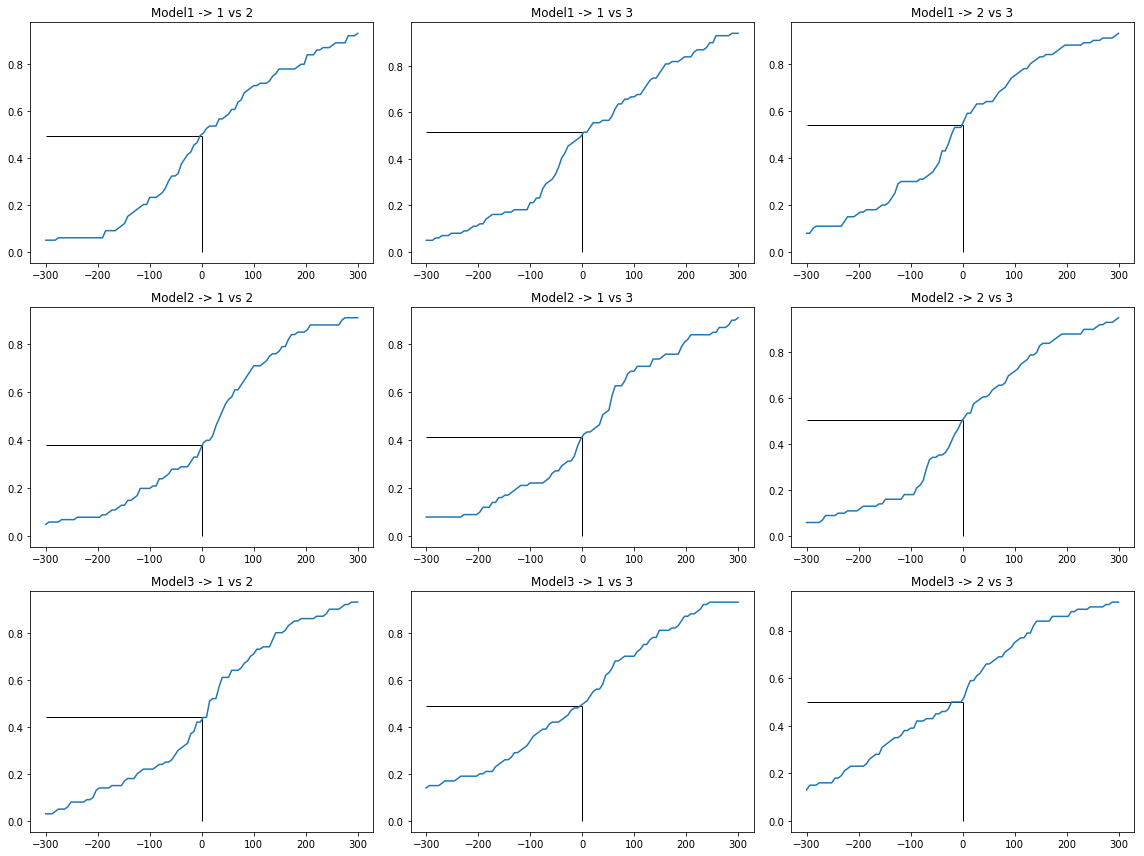

In [33]:
_ = plot_paired_data(data, comparison_uni_paired(-300, 300))

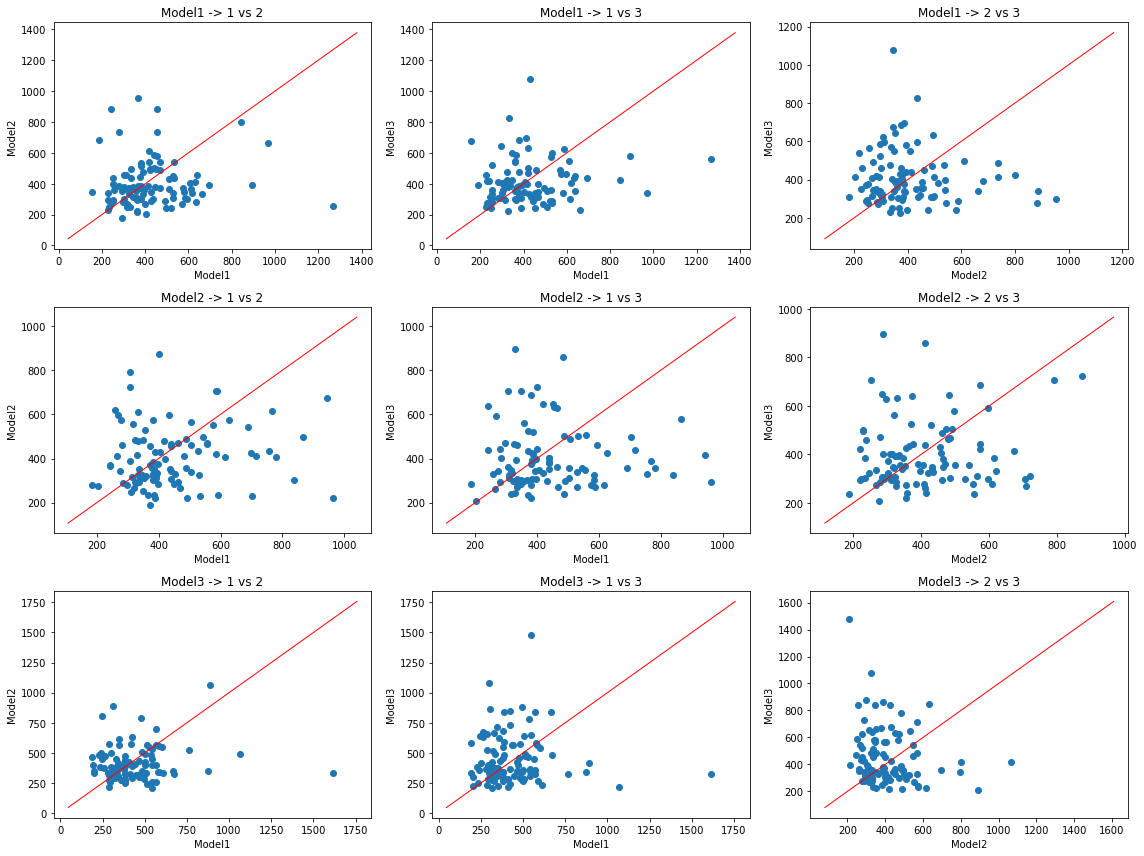

In [34]:
label_scatter_uni_paired(*plot_paired_data(data, scatter_uni_paired_plot_func))

# Brier score

In [35]:
data = process(all_preds, open_cp.evaluation.brier_score)

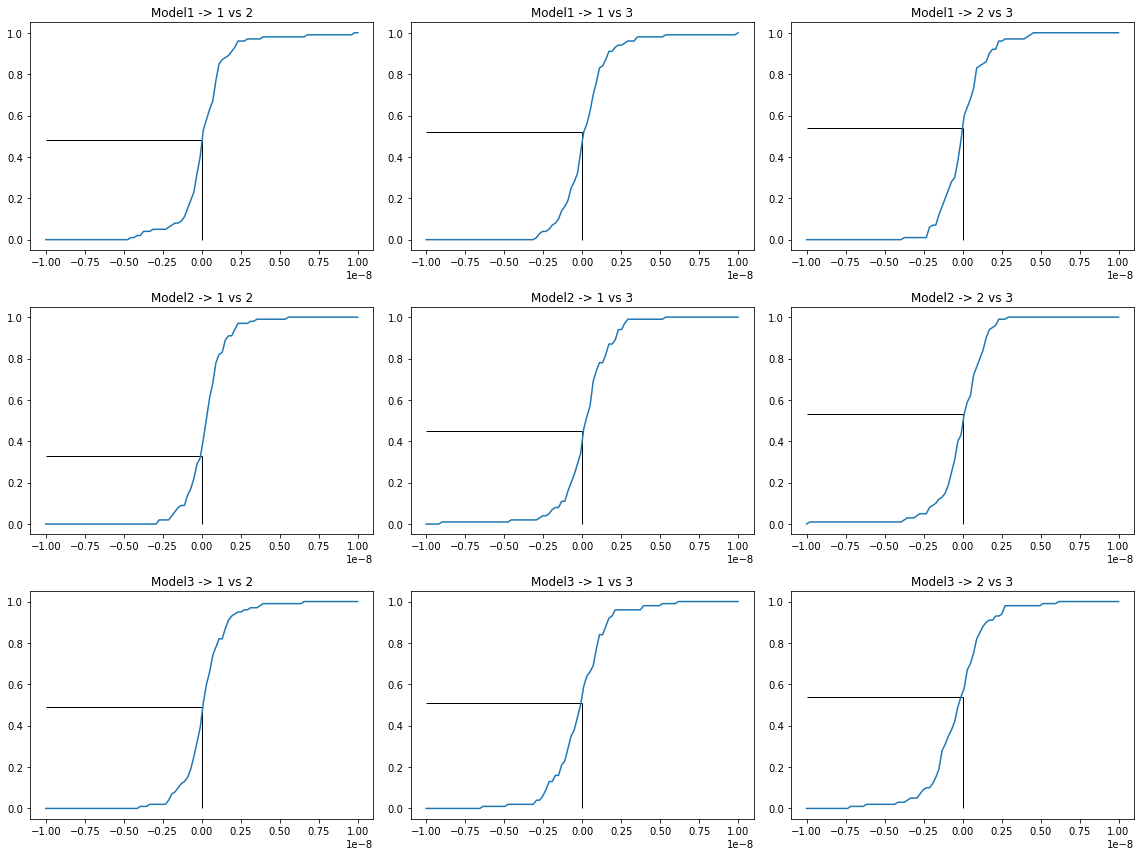

In [45]:
new_data = {k:v[0] for k,v in data.items()}
d = 1e-8
_ = plot_paired_data(new_data, comparison_uni_paired(-d, d))

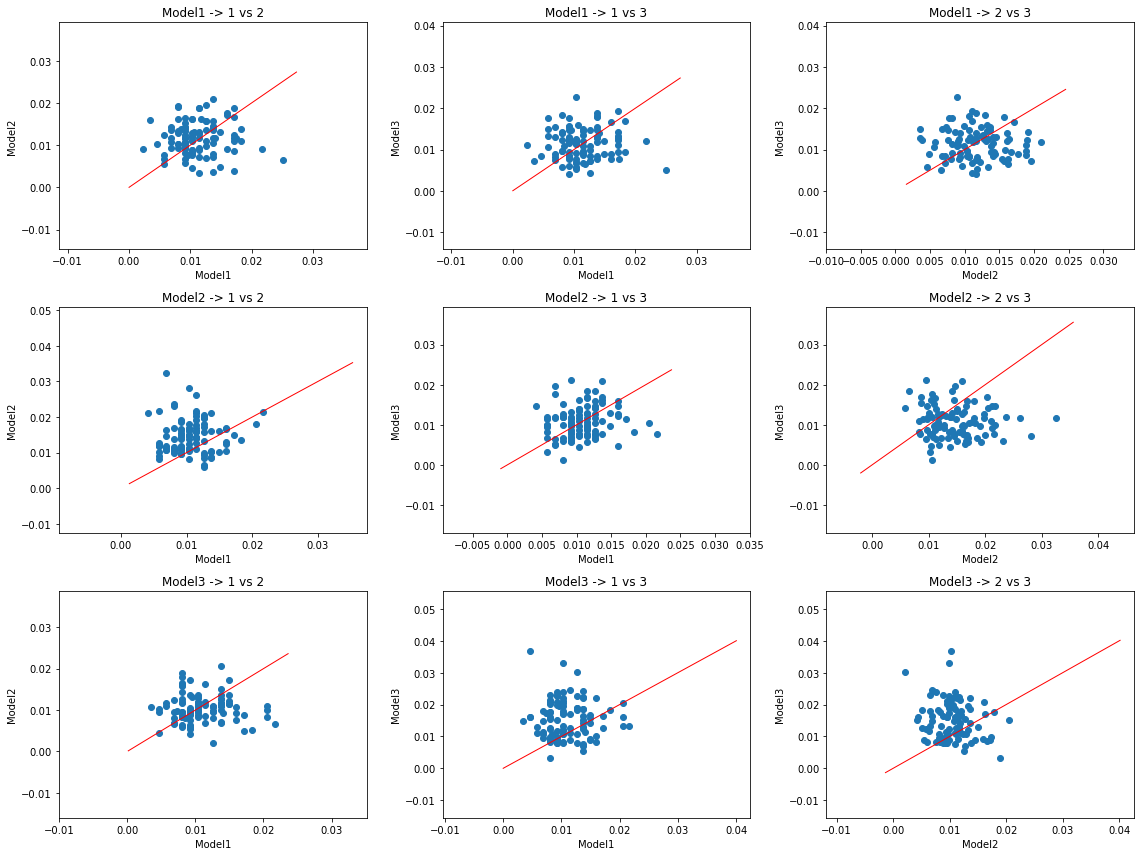

In [48]:
label_scatter_uni_paired(*plot_paired_data(new_data, scatter_uni_paired_plot_func))

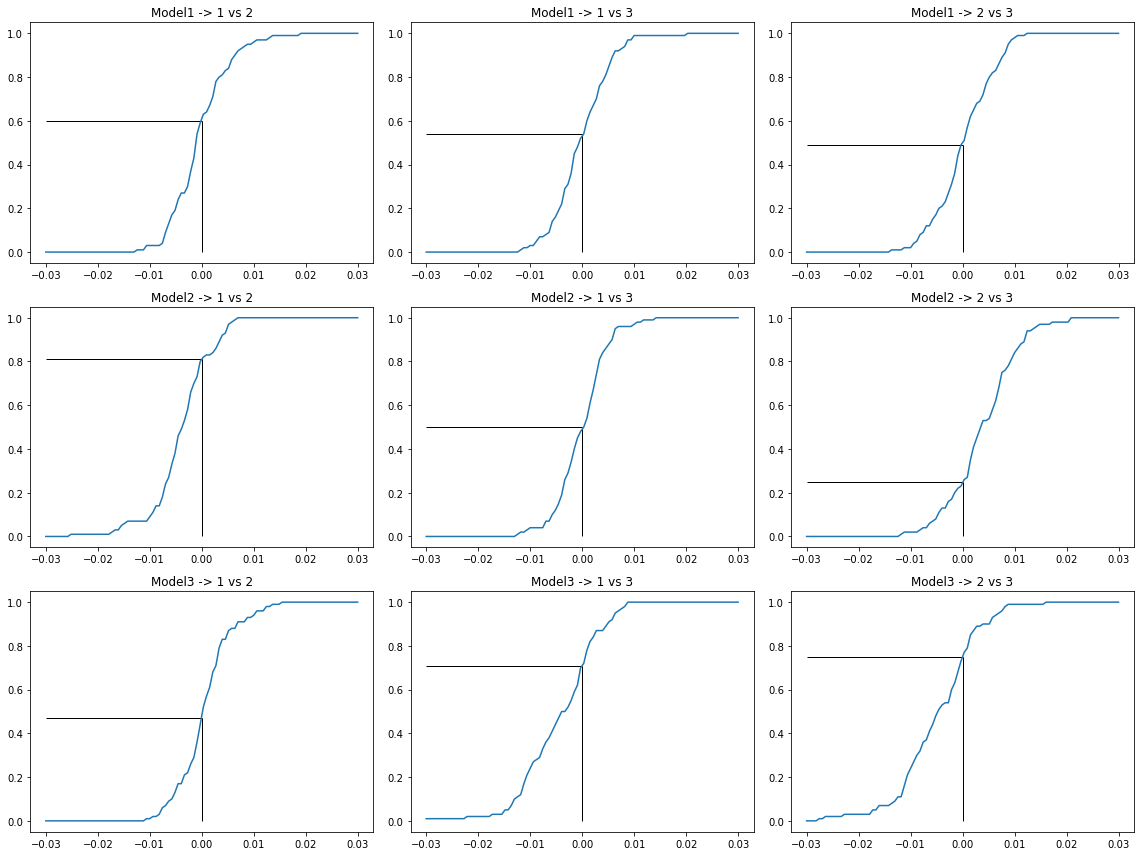

In [54]:
new_data = {k:v[1] for k,v in data.items()}
d = 0.03
_ = plot_paired_data(new_data, comparison_uni_paired(-d, d))

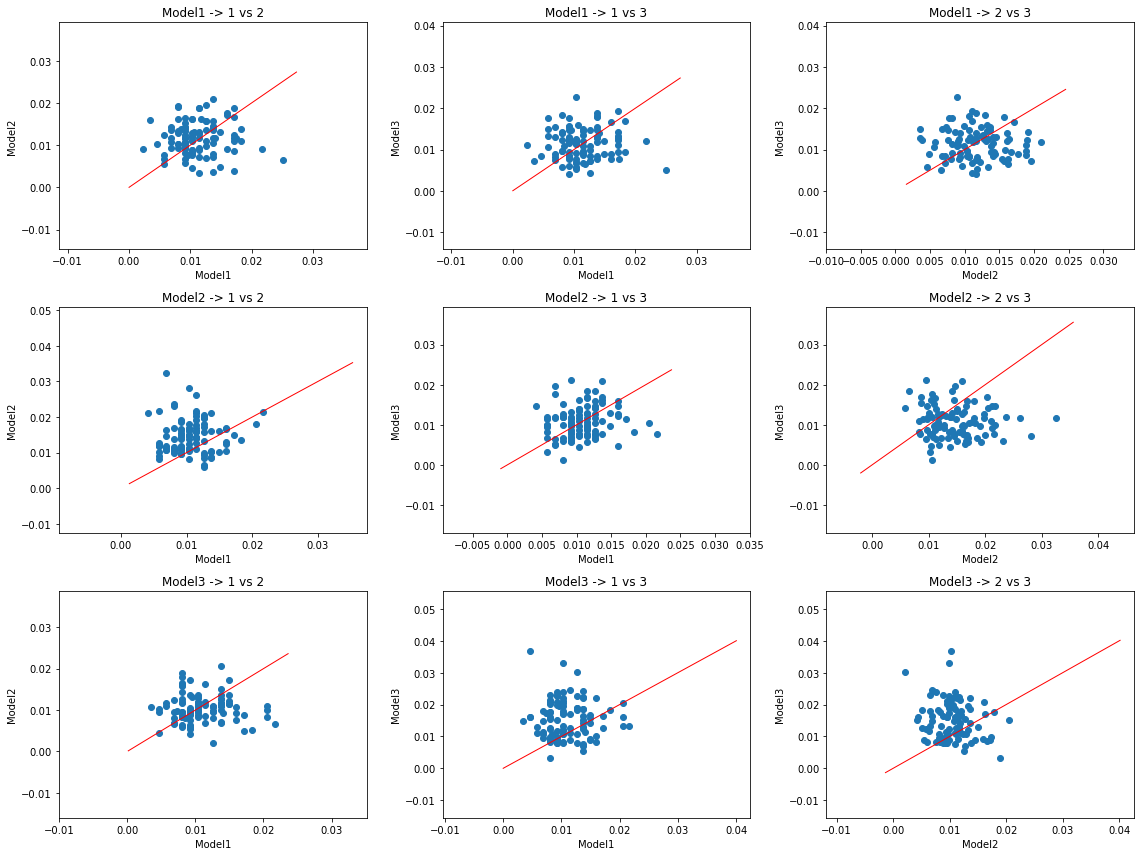

In [55]:
label_scatter_uni_paired(*plot_paired_data(new_data, scatter_uni_paired_plot_func))

### Multiscale Brier

In [13]:
data = process(all_preds, multiscale_brier)

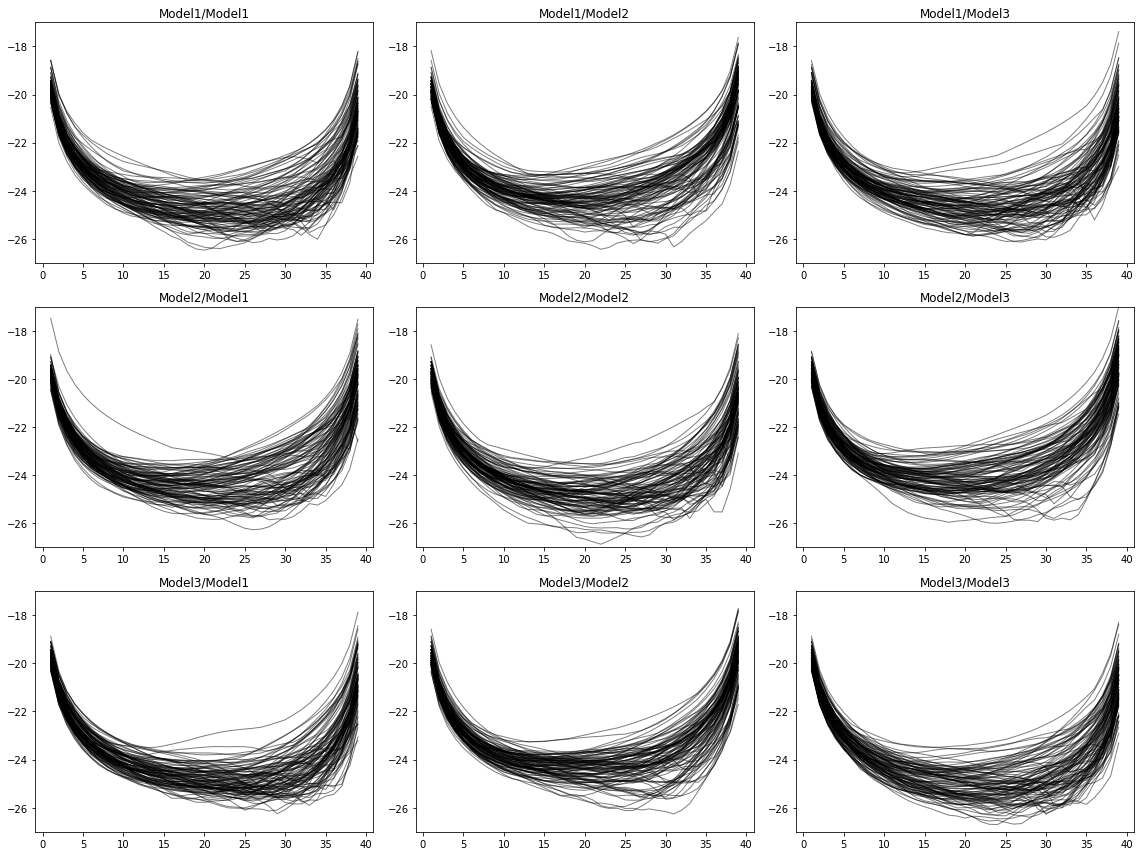

In [14]:
def plot_func(result, ax, key):
    for data in result:
        x = list(data)
        # Score
        y = [data[t][0] for t in x]
        ax.plot(x, np.log(y), color="black", linewidth=1, alpha=0.5)
        ax.set(ylim=[-27,-17])
    
plot_models(data, plot_func)

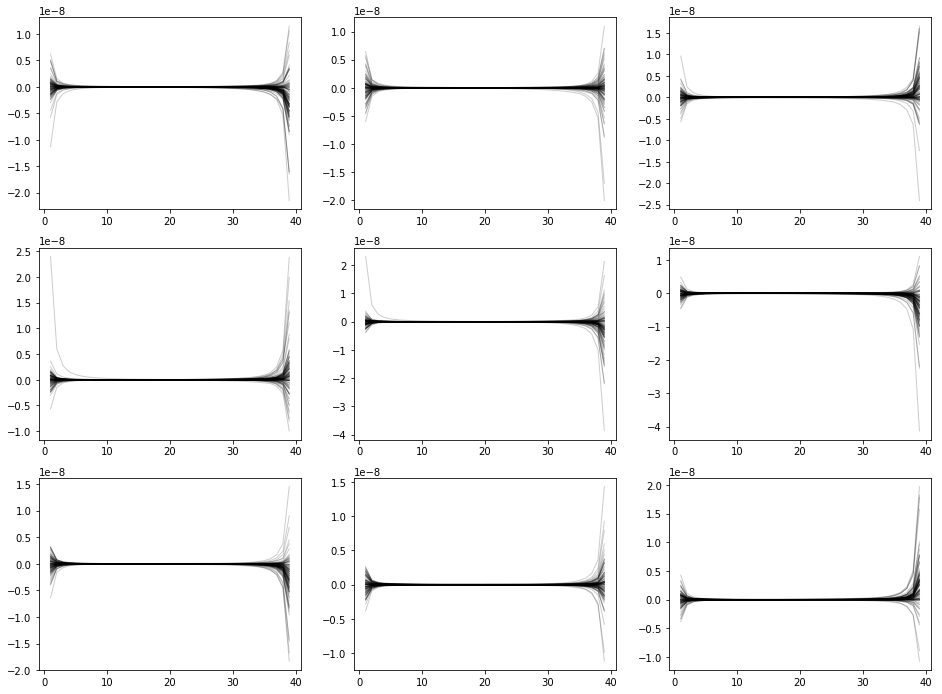

In [41]:
def plot_func(ax, paired_data):
    for d in paired_data:
        x = list(d.one)
        y = [d.one[t][0] - d.two[t][0] for t in x]
        ax.plot(x, y, color="black", linewidth=1, alpha=0.2)
        
plot_paired_data(data, plot_func)

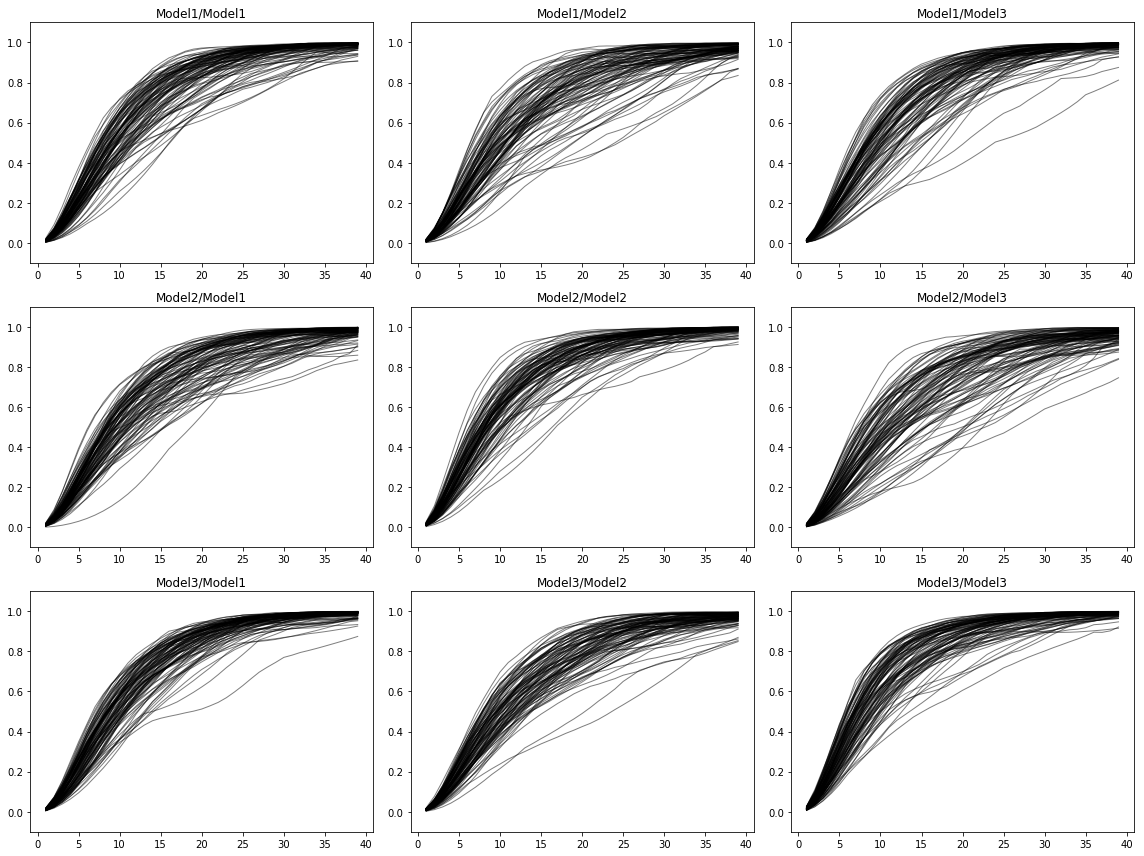

In [15]:
def plot_func(result, ax, key):
    for data in result:
        x = list(data)
        # Skill
        y = [data[t][1] for t in x]
        ax.plot(x, y, color="black", linewidth=1, alpha=0.5)
        ax.set(ylim=[-0.1, 1.1])
    
plot_models(data, plot_func)

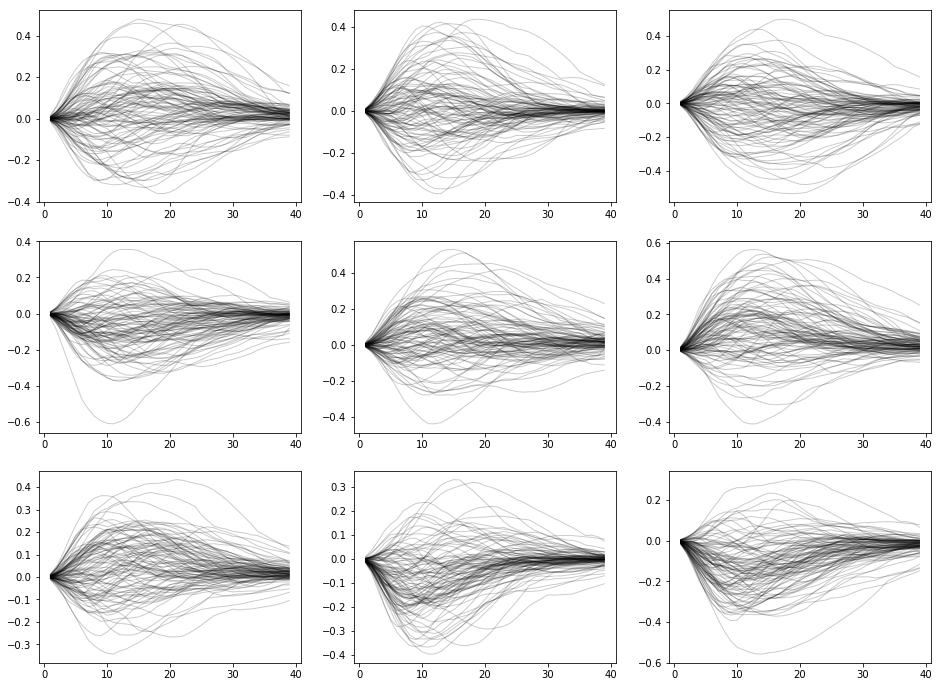

In [42]:
def plot_func(ax, paired_data):
    for d in paired_data:
        x = list(d.one)
        y = [d.one[t][1] - d.two[t][1] for t in x]
        ax.plot(x, y, color="black", linewidth=1, alpha=0.2)
        
plot_paired_data(data, plot_func)

## KL Skill

In [ ]:
data = process(all_preds, open_cp.evaluation.kl_score(pred, tps))

In [ ]:
def plot_func(result, ax, key):
    bins = np.linspace(1e-7, 2e-7, 20)
    ax.hist(result, bins)

plot_models(plot_func)

### Multiscale KL Score

In [ ]:
data = process(all_preds, multiscale_kl)

In [ ]:
def plot_func(result, ax, key):
    for data in result:
        x = list(data)
        y = [data[t] for t in x]
        ax.plot(x, np.log(y), color="black", linewidth=1, alpha=0.5)
        #ax.set(ylim=[-27,-17])
    
plot_models(plot_func)

## Bayesian

In [ ]:
data = { key+(i,) : open_cp.evaluation.bayesian_dirichlet_prior(pred, tps, bias=1)
        for i, (key, pred, tps) in enumerate(generate_data_preds()) }

In [ ]:
def plot_func(results, ax, key):
    for key, result in results.items():
        kernel = scipy.stats.kde.gaussian_kde(result)
        x = np.linspace(10, 140, 50)
        ax.plot(x, kernel(x), label=str(key))
    ax.legend()
    
plot_three(plot_func)

## Bayesian posterior

Look at how the predictive categorical prediction changes from the prior (informed only by our prediction) to the posterior (informed by data and our prediction).

We can vary the "bias" which is how much to weight the prior by.  A smaller value leads to the data having more effect.

In [ ]:
data = { key+(i,) : open_cp.evaluation.bayesian_predictive(pred, tps, bias=.01)
        for i, (key, pred, tps) in enumerate(generate_data_preds()) }

In [ ]:
def plot_func(results, ax, key):
    for key, result in results.items():
        kernel = scipy.stats.kde.gaussian_kde(result)
        x = np.linspace(2, 10, 150)
        ax.plot(x, kernel(x), label=str(key))
    ax.legend()
    
plot_three(plot_func)

In [ ]:
data = { key+(i,) : open_cp.evaluation.bayesian_predictive(pred, tps, bias=.1)
        for i, (key, pred, tps) in enumerate(generate_data_preds()) }
plot_three(plot_func)

In [ ]:
data = { key+(i,) : open_cp.evaluation.bayesian_predictive(pred, tps, bias=1)
        for i, (key, pred, tps) in enumerate(generate_data_preds()) }
plot_three(plot_func)

In [ ]:
data = { key+(i,) : open_cp.evaluation.bayesian_predictive(pred, tps, bias=10)
        for i, (key, pred, tps) in enumerate(generate_data_preds()) }

In [ ]:
def plot_func(results, ax, key):
    for key, result in results.items():
        kernel = scipy.stats.kde.gaussian_kde(result)
        x = np.linspace(0, 4, 150)
        ax.plot(x, kernel(x), label=str(key))
    ax.legend()
plot_three(plot_func)